# Семинар 3 "Матричное разложение"

**План:**
    
    - ALS from scratch
    
    - MF w/o features
    
    - MF with features
    
    - Hot, warm and cold scenarios
    
    - Factors

# ALS from scratch

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

$$
\begin{aligned}
&\frac{\partial L}{\partial p_u}=0 \Rightarrow p_u=\left(Q^TC_u Q+\lambda I\right)^{-1} Q^T C_u \phi_u \\
&\frac{\partial L}{\partial q_i}=0 \Rightarrow q_i=\left(P^TC_i P+\lambda I\right)^{-1} P^T C_i \phi_i
\end{aligned}
$$

$$
\begin{aligned}
&\frac{\partial L}{\partial p_u}=0 \Rightarrow p_u=\left(Q^T Q+Q^T\left(C_u-I\right) Q+\lambda I\right)^{-1} Q^T C_u \phi_u \\
&\frac{\partial L}{\partial q_i}=0 \Rightarrow q_i=\left(P^T P+P^T\left(C_i-I\right) P+\lambda I\right)^{-1} P^T C_i \phi_i
\end{aligned}
$$

$$ L\left(p_u, q_i, r_{u i}\right)=\sum_{u, i \in R} c_{u i} \cdot\left(\phi_{u i}-\langle p_u, q_i \rangle\right)^2=\sum_{u, i \in R}\left(1+\alpha r_{u i}\right)\left(\phi_{u i}-\langle p_u, q_i \rangle\right)^2 $$

Для более легкого понимания: [A gentle introduction to Alternating Least Squares](https://sophwats.github.io/2018-04-05-gentle-als.html)

Не вошло в ссылки лекции: [Учебник по машинному обучению. 9.2. Рекомендации на основе матричных разложений](
https://education.yandex.ru/handbook/ml/article/rekomendacii-na-osnove-matrichnyh-razlozhenij)

In [2]:
class ImplicitALS:
    def __init__(self, R, k=3, a=40, l2=10):
        self.l2 = l2
        self.k = k
        self.a = a
        self.m, self.n = R.shape

        # Инициализируем эмбеддинги пользователей (P) и товаров (Q)
        self.P = np.random.rand(self.m, self.k)
        self.Q = np.random.rand(self.n, self.k)

        self.phi = np.where(R > 0, 1, 0)  # CODE
        self.C = 1 + self.a * R  # CODE

        self.loss = []

    def train(self, n_step=10):
        l2_reg = self.l2 * np.identity(self.k)
        for _ in range(n_step):

            # fix P, update Q
            PtP = self.P.T.dot(self.P)
            for i in range(self.n):
                Ci = np.diag(self.C[:, i])  # CODE
                Wi = (
                    PtP + self.P.T.dot(Ci - np.identity(self.m)).dot(self.P) + l2_reg
                )  # CODE
                self.Q[i] = (
                    np.linalg.inv(Wi).dot(self.P.T).dot(Ci).dot(self.phi[:, i])
                )  # CODE

            # fix Q, update P
            QtQ = self.Q.T.dot(self.Q)
            for u in range(self.m):
                Cu = np.diag(self.C[u, :])  # CODE
                Wu = (
                    QtQ + self.Q.T.dot(Cu - np.identity(self.n)).dot(self.Q) + l2_reg
                )  # CODE
                self.P[u] = (
                    np.linalg.inv(Wu).dot(self.Q.T).dot(Cu).dot(self.phi[u, :])
                )  # CODE

            # Вычисляем LOSS
            loss = (self.C * (self.phi - self.P.dot(self.Q.T)) ** 2).sum()  # СODE
            l2_all = (self.P**2).sum() + (self.Q**2).sum()
            loss_with_l2_reg = loss + self.l2 * l2_all  # CODE
            self.loss.append(loss_with_l2_reg)

    def predict(self, u, i):
        return self.P[u].dot(self.Q[i])  # CODE

In [3]:
np.random.seed(42)

In [4]:
stars = np.arange(6)
p = np.array([10, 1, 1, 1, 1, 1])
m = 5  # Кол-во пользователей
n = 10  # Кол-во товаров

ratings = np.random.choice(stars, size=m * n, p=p / p.sum()).reshape((m, n))

ratings

array([[0, 5, 1, 0, 0, 0, 0, 3, 0, 1],
       [0, 5, 3, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 5, 5, 3, 0, 0, 1, 0],
       [0, 0, 0, 4, 0, 0, 0, 0, 0, 0]])

In [5]:
ratings.shape

(5, 10)

In [6]:
als = ImplicitALS(R=ratings, k=20)

In [7]:
als.phi

array([[0, 1, 1, 0, 0, 0, 0, 1, 0, 1],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [8]:
als.C

array([[  1, 201,  41,   1,   1,   1,   1, 121,   1,  41],
       [  1, 201, 121,   1,   1,   1,   1,   1,   1,   1],
       [  1,   1,   1,   1,   1,  81,   1,   1,   1,   1],
       [  1,   1,   1, 201, 201, 121,   1,   1,  41,   1],
       [  1,   1,   1, 161,   1,   1,   1,   1,   1,   1]])

In [9]:
als.train(n_step=50)

In [10]:
als.loss[:5]

[245.4379444812453,
 190.01384136209344,
 165.3269542557215,
 151.22063653819072,
 142.5106345804081]

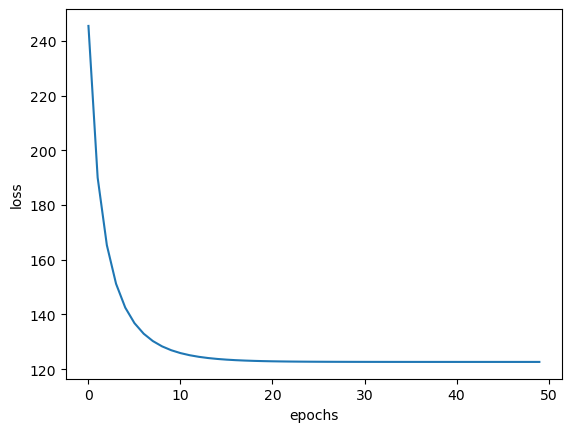

In [11]:
ax = sns.lineplot(als.loss)
ax.set_xlabel("epochs")
ax.set_ylabel("loss")

In [12]:
assert als.P.shape[0] == ratings.shape[0]
assert als.Q.shape[0] == ratings.shape[1]
assert als.P.shape[1] == als.Q.shape[1]

In [13]:
# Предскажем для всех
pred_ratings = np.matmul(als.P, als.Q.T).round(2)
pred_ratings

array([[ 0.  ,  1.  ,  0.98, -0.  ,  0.  ,  0.  ,  0.  ,  0.94,  0.  ,
         0.84],
       [ 0.  ,  0.96,  0.94,  0.  , -0.  , -0.  ,  0.  ,  0.83, -0.  ,
         0.74],
       [ 0.  , -0.  , -0.  ,  0.23,  0.55,  0.88,  0.  ,  0.  ,  0.49,
         0.  ],
       [ 0.  , -0.  , -0.  ,  0.99,  0.96,  0.99,  0.  ,  0.  ,  0.85,
         0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.94,  0.56,  0.24,  0.  , -0.  ,  0.49,
        -0.  ]])

In [14]:
ratings

array([[0, 5, 1, 0, 0, 0, 0, 3, 0, 1],
       [0, 5, 3, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 5, 5, 3, 0, 0, 1, 0],
       [0, 0, 0, 4, 0, 0, 0, 0, 0, 0]])

In [15]:
for row_idx in range(ratings.shape[0]):
    print("Original:")
    print(ratings[row_idx, :])
    print("Predicted:")
    print(pred_ratings[row_idx, :])
    print("-----------")

Original:
[0 5 1 0 0 0 0 3 0 1]
Predicted:
[ 0.    1.    0.98 -0.    0.    0.    0.    0.94  0.    0.84]
-----------
Original:
[0 5 3 0 0 0 0 0 0 0]
Predicted:
[ 0.    0.96  0.94  0.   -0.   -0.    0.    0.83 -0.    0.74]
-----------
Original:
[0 0 0 0 0 2 0 0 0 0]
Predicted:
[ 0.   -0.   -0.    0.23  0.55  0.88  0.    0.    0.49  0.  ]
-----------
Original:
[0 0 0 5 5 3 0 0 1 0]
Predicted:
[ 0.   -0.   -0.    0.99  0.96  0.99  0.    0.    0.85  0.  ]
-----------
Original:
[0 0 0 4 0 0 0 0 0 0]
Predicted:
[ 0.    0.    0.    0.94  0.56  0.24  0.   -0.    0.49 -0.  ]
-----------


# ALS from Rectools

In [2]:
import os
import requests
import threadpoolctl
import warnings
import typing as tp
from tqdm import tqdm
from pathlib import Path

import pandas as pd
import plotly.express as px
import numpy as np
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization
import matplotlib.pyplot as plt
import seaborn as sns
from lightfm import LightFM

from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import (
    Precision,
    Recall,
    MAP,
    MeanInvUserFreq,
    NDCG,
    Serendipity,
    calc_metrics,
)
from rectools.models import (
    PopularModel,
    RandomModel,
    PureSVDModel,
    ImplicitALSWrapperModel,
    LightFMWrapperModel,
)

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

# For implicit ALS
os.environ["OPENBLAS_NUM_THREADS"] = "1"
threadpoolctl.threadpool_limits(1, "blas")

## Датасет KION

In [117]:
if not (
    Path("./data_original/interactions.csv").is_file()
    & Path("./data_original/items.csv").is_file()
    & Path("./data_original/users.csv").is_file()
):
    url = "https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip"
    req = requests.get(url, stream=True)

    with open("kion_train.zip", "wb") as fd:
        total_size_in_bytes = int(req.headers.get("Content-Length", 0))
        progress_bar = tqdm(
            desc="Downloading the kion dataset...",
            total=total_size_in_bytes,
            unit="iB",
            unit_scale=True,
        )
        for chunk in req.iter_content(chunk_size=2**20):
            progress_bar.update(len(chunk))
            fd.write(chunk)

In [121]:
!unzip -f kion_train.zip -x '__MACOSX/*'

Archive:  kion_train.zip


In [21]:
BASE_PATH = Path("./data_original")

In [22]:
interactions = pd.read_csv(BASE_PATH / "interactions.csv")
users = pd.read_csv(BASE_PATH / "users.csv")
items = pd.read_csv(BASE_PATH / "items.csv")

In [23]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [24]:
# переименовываем поля в понятные для RecTools

interactions = interactions.rename(
    columns={"total_dur": Columns.Weight, "last_watch_dt": Columns.Datetime}
)

interactions["datetime"] = pd.to_datetime(interactions["datetime"])

# Interactions

In [25]:
interactions.head()

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [26]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int64         
 1   item_id      int64         
 2   datetime     datetime64[ns]
 3   weight       int64         
 4   watched_pct  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


In [27]:
print(f"Interactions shape {interactions.shape}")
print(f"Unique users in interactions: {interactions['user_id'].nunique():_}")
print(f"Unique items in interactions: {interactions['item_id'].nunique():_}")
print(f"min date in interactions: {interactions['datetime'].min()}")
print(f"max date in interactions: {interactions['datetime'].max()}")

Interactions shape (5476251, 5)
Unique users in interactions: 962_179
Unique items in interactions: 15_706
min date in interactions: 2021-03-13 00:00:00
max date in interactions: 2021-08-22 00:00:00


# Users

In [28]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [29]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


In [30]:
print(f"Users shape {users.shape}")
print(f"Unique users: {users['user_id'].nunique():_}")

Users shape (840197, 5)
Unique users: 840_197


# Items

In [31]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [32]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


In [33]:
print(f"Items dataframe shape {items.shape}")
print(f"Unique item_id: {items['item_id'].nunique():_}")

Items dataframe shape (15963, 14)
Unique item_id: 15_963


# Train test split

In [34]:
min_date = interactions["datetime"].min()
max_date = interactions["datetime"].max()

print(f"min date in interactions: {min_date}")
print(f"max date in interactions: {max_date}")

min date in interactions: 2021-03-13 00:00:00
max date in interactions: 2021-08-22 00:00:00


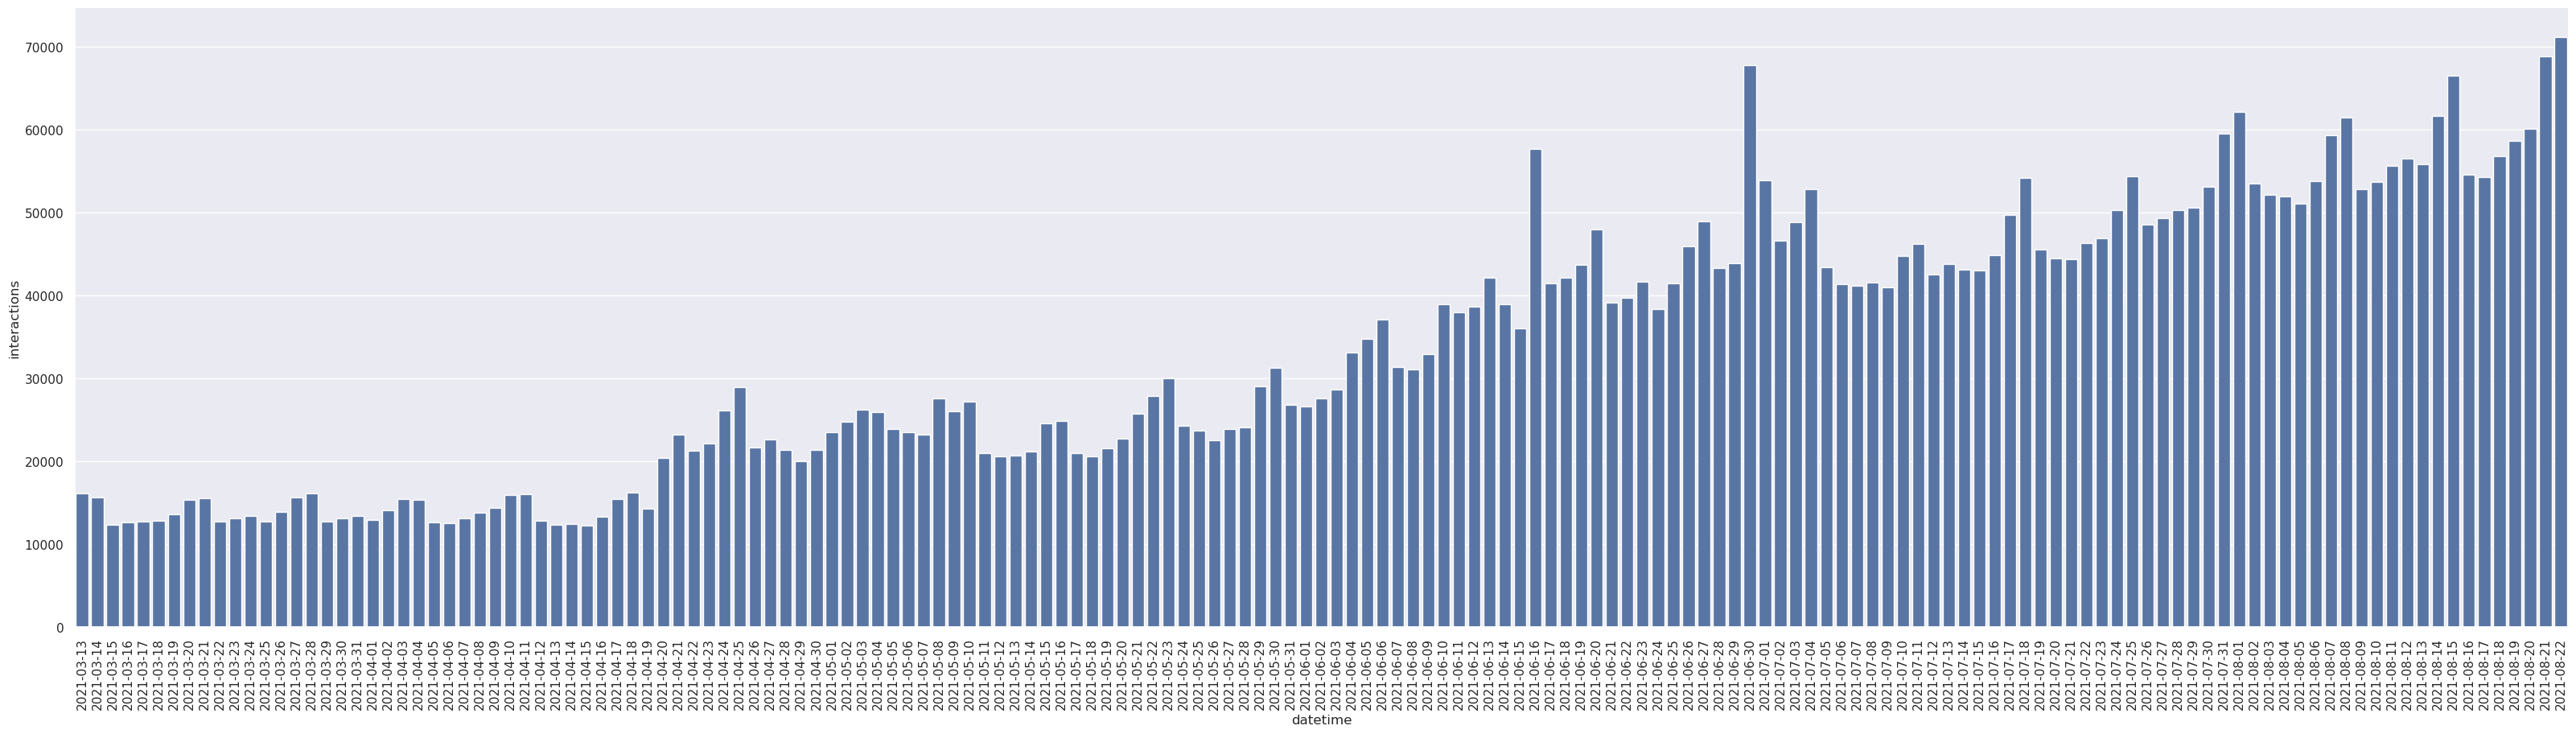

In [130]:
daily_iters = interactions.groupby(Columns.Datetime)[Columns.Datetime].agg("count")
daily_iters.name = "interactions"

sns.set_theme(rc={"figure.figsize": (40, 10)})
ax = sns.barplot(daily_iters)
plt.xticks(rotation=90)

Из графика распределения интеракций по дням можно заметить **недельные тренды** -> **на валидацию и тест можем брать по одной неделе**

In [36]:
max_date = interactions["datetime"].max()

train = interactions[(interactions["datetime"] < max_date - pd.Timedelta(days=7))]
test = interactions[(interactions["datetime"] >= max_date - pd.Timedelta(days=7))]

# оставляем только горячих пользователей в тесте
test_hot = test[test["user_id"].isin(train["user_id"].unique())]

print(f"train: {train.shape}")
print(f"test hot: {test_hot.shape}")

train: (4985269, 5)
test hot: (349088, 5)


# Models w/o features

Создаем rectools.Dataset без фичей:

In [37]:
dataset = Dataset.construct(
    interactions_df=train, user_features_df=None, item_features_df=None
)

In [23]:
K_RECOS = 10
RANDOM_STATE = 42
NUM_THREADS = 16
N_FACTORS = 4

**Объявляем простые модели**

In [39]:
models = {
    "random": RandomModel(random_state=RANDOM_STATE),
    "popular": PopularModel(),
    "most_raited": PopularModel(popularity="sum_weight"),
}

**Объявляем модели MF**

In [40]:
implicit_models = {
    "ALS": AlternatingLeastSquares,
    "BPR": BayesianPersonalizedRanking,
    "LMF": LogisticMatrixFactorization,
}
for implicit_name, implicit_model in implicit_models.items():
    models[f"{implicit_name}_factors_{N_FACTORS}"] = ImplicitALSWrapperModel(
        model=implicit_model(
            factors=N_FACTORS,
            random_state=RANDOM_STATE,
            num_threads=NUM_THREADS,
            # iterations=30,
        )
    )

In [41]:
lightfm_losses = ("logistic", "bpr", "warp")

for loss in lightfm_losses:
    models[f"LightFM_{loss}_factors_{N_FACTORS}"] = LightFMWrapperModel(
        LightFM(
            no_components=N_FACTORS,
            loss=loss,
            random_state=RANDOM_STATE,
        ),
        epochs=10,
        num_threads=NUM_THREADS,
    )

In [42]:
models[f"PureSVD_{N_FACTORS}"] = PureSVDModel(factors=N_FACTORS)

In [43]:
models

{'random': <rectools.models.random.RandomModel at 0x7b27d3ae2290>,
 'popular': <rectools.models.popular.PopularModel at 0x7b27b4b4b3d0>,
 'most_raited': <rectools.models.popular.PopularModel at 0x7b27d39a5190>,
 'ALS_factors_4': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7b27b4b725d0>,
 'BPR_factors_4': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7b27b4ba83d0>,
 'LMF_factors_4': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7b27d3a84c10>,
 'LightFM_logistic_factors_4': <rectools.models.lightfm.LightFMWrapperModel at 0x7b27d3901dd0>,
 'LightFM_bpr_factors_4': <rectools.models.lightfm.LightFMWrapperModel at 0x7b27d37353d0>,
 'LightFM_warp_factors_4': <rectools.models.lightfm.LightFMWrapperModel at 0x7b27d38ae310>,
 'PureSVD_4': <rectools.models.pure_svd.PureSVDModel at 0x7b27d3886c90>}

In [44]:
# Объявляем метрики
metrics_name = {
    "precision": Precision,
    "recall": Recall,
    "ndcg": NDCG,
    "serendipity": Serendipity,
    "novelty": MeanInvUserFreq,
}
K = [3, 5, 10]


metrics = {}
for metric_name, metric in metrics_name.items():
    for k in K:
        metrics[f"{metric_name}@{k}"] = metric(k=k)
metrics

{'precision@3': Precision(k=3),
 'precision@5': Precision(k=5),
 'precision@10': Precision(k=10),
 'recall@3': Recall(k=3),
 'recall@5': Recall(k=5),
 'recall@10': Recall(k=10),
 'ndcg@3': NDCG(k=3, log_base=2),
 'ndcg@5': NDCG(k=5, log_base=2),
 'ndcg@10': NDCG(k=10, log_base=2),
 'serendipity@3': Serendipity(k=3),
 'serendipity@5': Serendipity(k=5),
 'serendipity@10': Serendipity(k=10),
 'novelty@3': MeanInvUserFreq(k=3),
 'novelty@5': MeanInvUserFreq(k=5),
 'novelty@10': MeanInvUserFreq(k=10)}

In [47]:
catalog = train[Columns.Item].unique()

results = []
for model_name, model in tqdm(models.items()):
    model_quality = {"model": model_name}

    model.fit(dataset)
    recos = model.recommend(
        users=test_hot[Columns.User].unique(),
        dataset=dataset,
        k=K_RECOS,
        filter_viewed=True,  # Для чего этот параметр?
    )

    metric_values = calc_metrics(metrics, recos, test_hot, train, catalog=catalog)

    model_quality.update(metric_values)
    results.append(model_quality)

100%|██████████| 10/10 [03:06<00:00, 18.69s/it]


In [48]:
df_quality = pd.DataFrame(results).T

df_quality.columns = df_quality.iloc[0]

df_quality.drop("model", inplace=True)

In [49]:
df_quality.style.highlight_max(color="lightgreen", axis=1)

model,random,popular,most_raited,ALS_factors_4,BPR_factors_4,LMF_factors_4,LightFM_logistic_factors_4,LightFM_bpr_factors_4,LightFM_warp_factors_4,PureSVD_4
precision@3,0.000166,0.066225,0.049303,0.020271,0.026261,0.000044,0.000006,0.000000,0.065412,0.039128
recall@3,0.000161,0.100400,0.076340,0.032830,0.041706,0.000038,0.000002,0.000000,0.097361,0.061377
precision@5,0.000171,0.052735,0.036461,0.017861,0.020465,0.000055,0.000007,0.000002,0.053082,0.028520
recall@5,0.000293,0.130473,0.092314,0.046621,0.052768,0.000099,0.000006,0.000002,0.129057,0.073604
precision@10,0.000176,0.033708,0.029902,0.016555,0.014280,0.000066,0.000010,0.000002,0.035476,0.024375
recall@10,0.000636,0.163348,0.148263,0.085179,0.070918,0.000201,0.000018,0.000004,0.167321,0.121362
ndcg@3,0.000181,0.067825,0.054997,0.017856,0.029415,0.000038,0.000004,0.000000,0.069335,0.045404
ndcg@5,0.000180,0.058125,0.044439,0.016872,0.024539,0.000047,0.000005,0.000001,0.059769,0.036321
ndcg@10,0.000180,0.042932,0.037379,0.016288,0.018791,0.000058,0.000008,0.000002,0.045119,0.030618
novelty@3,15.622707,2.715712,3.476014,6.254801,8.742482,15.863335,17.540496,17.854312,3.065290,4.662294


**Ваши предположения:**

Почему LightFM в warp loss-ом показывает лучшие результаты по метрикам precision@k?

# Models with Features

## User features

In [50]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [51]:
users.isnull().sum()

user_id         0
age         14095
income      14776
sex         13831
kids_flg        0
dtype: int64

In [52]:
users.dtypes

user_id      int64
age         object
income      object
sex         object
kids_flg     int64
dtype: object

In [53]:
# Заменим пропуски значениями `Unknown`
users.fillna("Unknown", inplace=True)

In [54]:
users.nunique()

user_id     840197
age              7
income           7
sex              3
kids_flg         2
dtype: int64

**Рассмотрим распределение признаков пользователей**

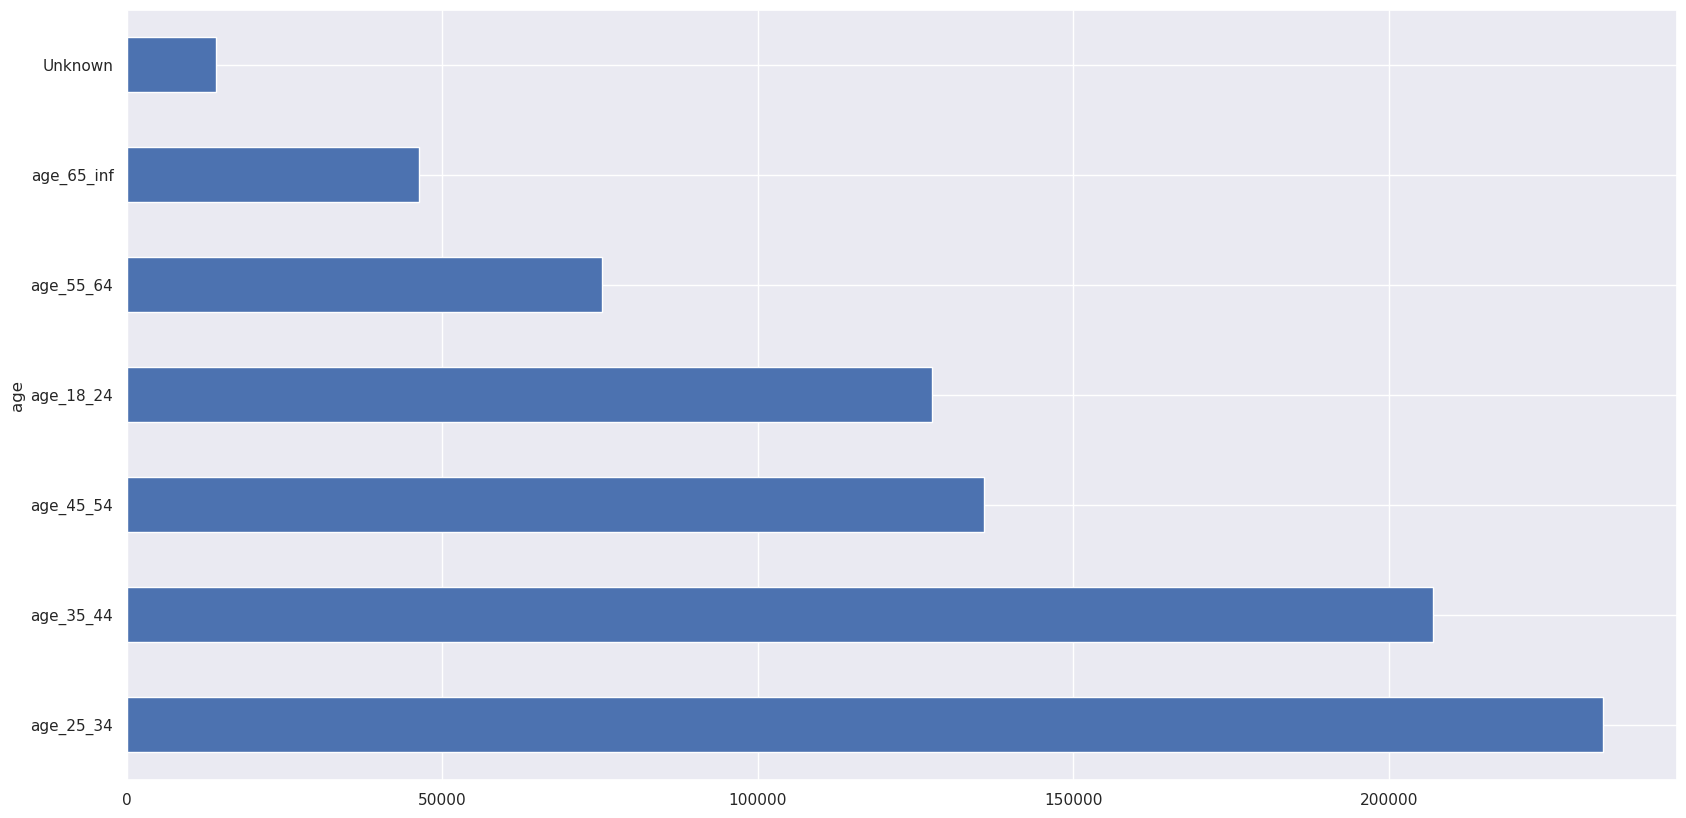

In [55]:
users["age"].value_counts().plot.barh()

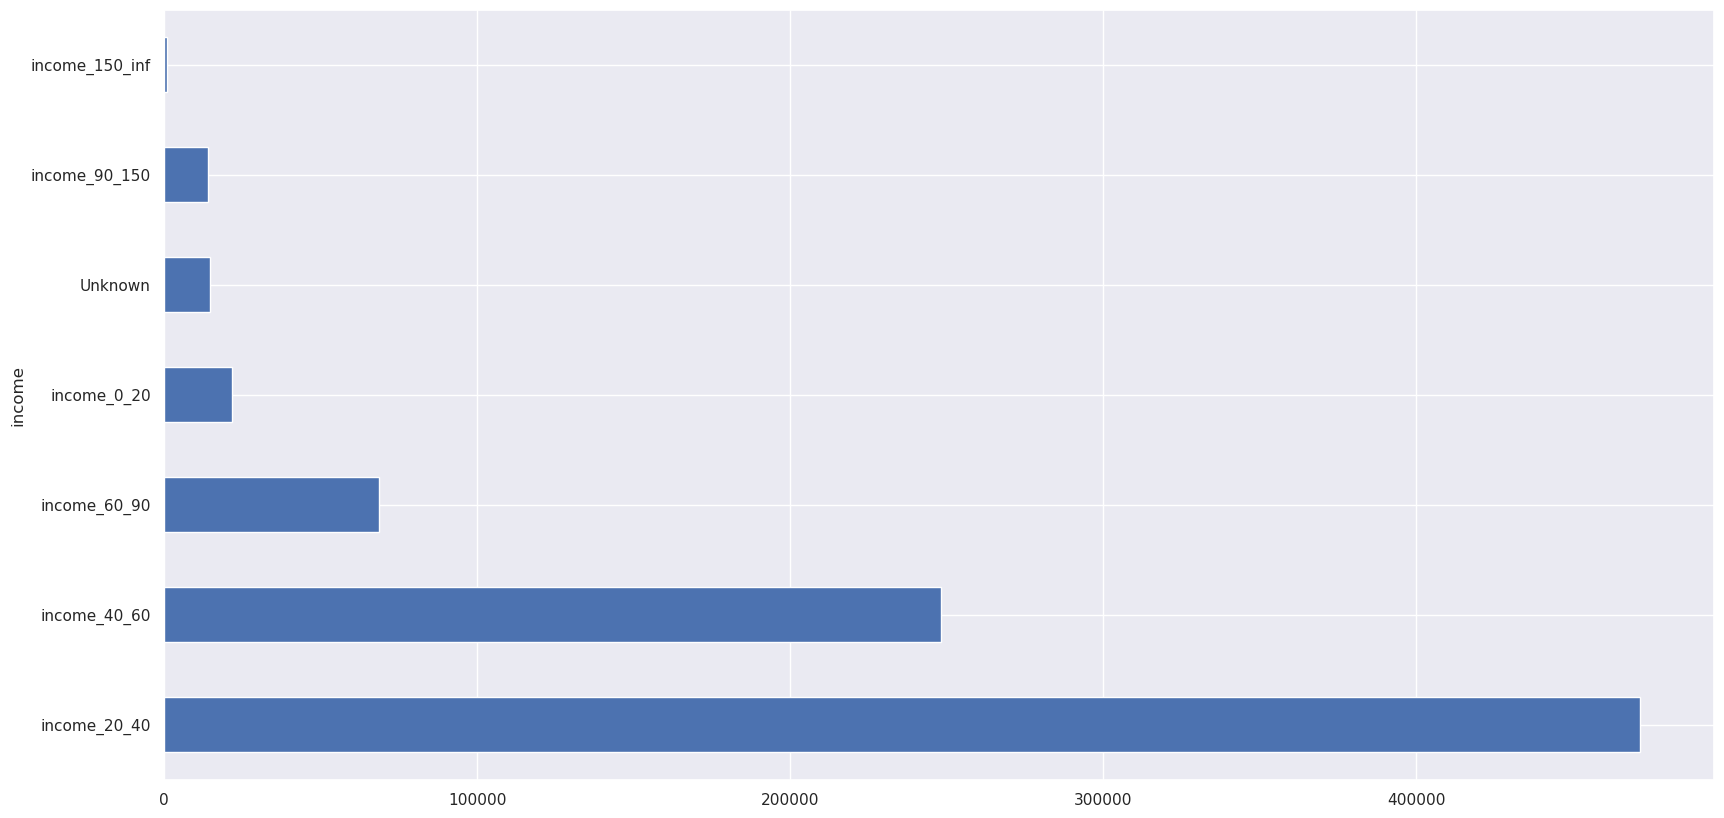

In [56]:
users["income"].value_counts().plot.barh()

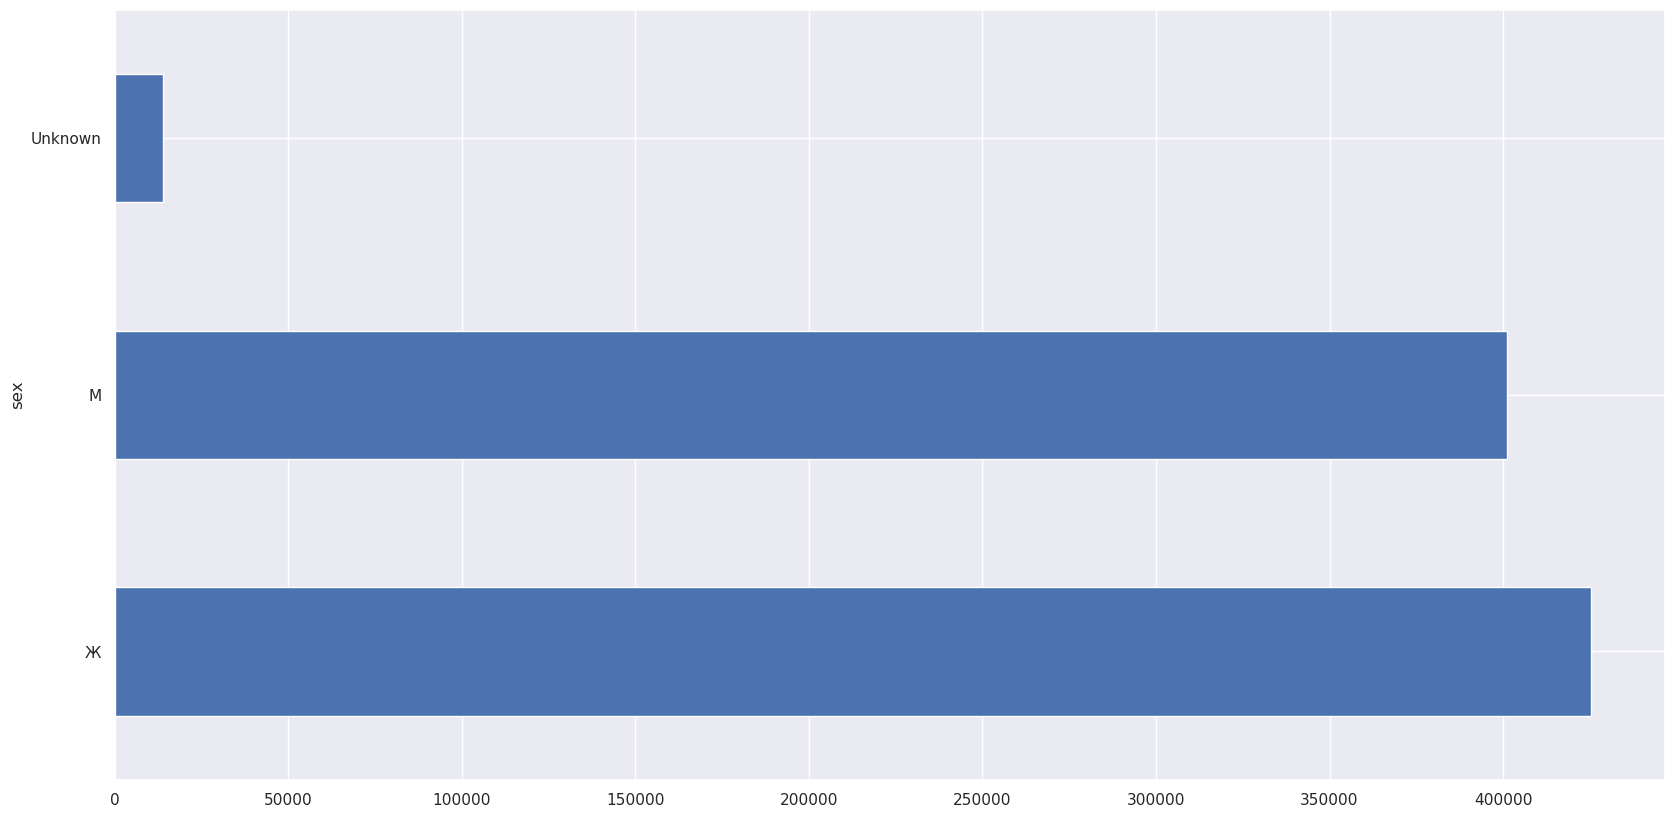

In [57]:
users["sex"].value_counts().plot.barh()

**Создадим датасет из фичей пользователей, взяв их соц-дем признаки `age`, `income`, `sex`**

In [58]:
FEATURES_COLUMNS = ["age", "income", "sex"]

user_features_dfs = []
for feature in FEATURES_COLUMNS:
    feature_df = users.reindex(columns=[Columns.User, feature])
    feature_df.columns = ["id", "value"]
    feature_df["feature"] = feature
    user_features_dfs.append(feature_df)
user_features_df = pd.concat(user_features_dfs, ignore_index=True)
user_features_df.head()

,id,value,feature
0,973171,age_25_34,age
1,962099,age_18_24,age
2,1047345,age_45_54,age
3,721985,age_45_54,age
4,704055,age_35_44,age


In [59]:
users[users[Columns.User] == 973171]

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1


In [60]:
user_features_df[user_features_df["id"] == 973171]

,id,value,feature
0,973171,age_25_34,age
840197,973171,income_60_90,income
1680394,973171,М,sex


## Item features

In [61]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [62]:
items.isnull().sum()

item_id             0
content_type        0
title               0
title_orig       4745
release_year       98
genres              0
countries          37
for_kids        15397
age_rating          2
studios         14898
directors        1509
actors           2619
description         2
keywords          423
dtype: int64

**Для фильтов возьмем следующие фичи: `content_type`, `genres`**

In [63]:
# Предварительно обратобтаем genres
items["genre"] = items["genres"].str.lower().str.split(", ")
genre_feature = items[[Columns.Item, "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [64]:
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"
content_feature.head()

,id,value,feature
0,10711,film,content_type
1,2508,film,content_type
2,10716,film,content_type
3,7868,film,content_type
4,16268,film,content_type


In [65]:
items_features_df = pd.concat(
    [content_feature, genre_feature],
    ignore_index=True,
)
items_features_df.head()

,id,value,feature
0,10711,film,content_type
1,2508,film,content_type
2,10716,film,content_type
3,7868,film,content_type
4,16268,film,content_type


In [66]:
items[items[Columns.Item] == 2508][[Columns.Item, "content_type", "genres"]]

,item_id,content_type,genres
1,2508,film,"зарубежные, приключения, комедии"


In [67]:
items_features_df[items_features_df["id"] == 2508]

,id,value,feature
1,2508,film,content_type
15967,2508,зарубежные,genre
15968,2508,приключения,genre
15969,2508,комедии,genre


**Cобираем rectools.Dataset c фичами:**

In [68]:
# Можем ли использовать фичи только для пользователей или товаров?

dataset_full_features = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features_df,
    cat_user_features=["sex", "age", "income"],
    item_features_df=items_features_df,
    cat_item_features=["genre", "content_type"],
)

dataset_with_features = {
    "full_features": dataset_full_features,
}

In [69]:
models_with_features = {}

IS_FITTING_FEATURES = (True, False)

In [70]:
for is_fit_feat in IS_FITTING_FEATURES:
    models_with_features[f"als_factors_{N_FACTORS}_fit_together_{is_fit_feat}"] = (
        ImplicitALSWrapperModel(
            model=AlternatingLeastSquares(
                factors=N_FACTORS,
                random_state=RANDOM_STATE,
                num_threads=NUM_THREADS,
            ),
            # train paried factors together with latent factors (fit_features_together=True)
            # or after training latent factors (fit_features_together=False)
            fit_features_together=is_fit_feat,
        )
    )

In [71]:
models_with_features

{'als_factors_4_fit_together_True': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7b27cd132150>,
 'als_factors_4_fit_together_False': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7b27ccf84990>}

In [72]:
lightfm_losses = ("bpr", "warp")

for loss in lightfm_losses:
    models_with_features[f"LightFM_{loss}_factors_{N_FACTORS}"] = LightFMWrapperModel(
        model=LightFM(
            no_components=N_FACTORS,
            loss=loss,
            random_state=RANDOM_STATE,
        ),
        epochs=10,
        num_threads=NUM_THREADS,
    )

In [73]:
models_with_features

{'als_factors_4_fit_together_True': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7b27cd132150>,
 'als_factors_4_fit_together_False': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7b27ccf84990>,
 'LightFM_bpr_factors_4': <rectools.models.lightfm.LightFMWrapperModel at 0x7b27adbbfe90>,
 'LightFM_warp_factors_4': <rectools.models.lightfm.LightFMWrapperModel at 0x7b27adbff950>}

In [74]:
catalog = train[Columns.Item].unique()

results = []
for model_name, model in tqdm(models_with_features.items()):
    for dataset_name, dataset_feat in dataset_with_features.items():
        model_quality_feature = {"model": f"model_{model_name}-dataset_{dataset_name}"}
        print(f"{model_quality_feature['model']}...")

        model.fit(dataset_feat)
        recos = model.recommend(
            users=test_hot[Columns.User].unique(),
            dataset=dataset_feat,
            k=K_RECOS,
            filter_viewed=True,
        )

        metric_values = calc_metrics(
            metrics,
            recos,
            test_hot,
            train,
            catalog=catalog,
        )

        model_quality_feature.update(metric_values)
        results.append(model_quality_feature)

model_als_factors_4_fit_together_True-dataset_full_features...


model_als_factors_4_fit_together_False-dataset_full_features...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

model_LightFM_bpr_factors_4-dataset_full_features...


model_LightFM_warp_factors_4-dataset_full_features...


100%|██████████| 4/4 [02:24<00:00, 36.22s/it]


In [75]:
df_quality_feature = pd.DataFrame(results).T

df_quality_feature.columns = df_quality_feature.iloc[0]

df_quality_feature.drop("model", inplace=True)

In [76]:
df_quality_feature.style.highlight_max(color="lightgreen", axis=1)

model,model_als_factors_4_fit_together_True-dataset_full_features,model_als_factors_4_fit_together_False-dataset_full_features,model_LightFM_bpr_factors_4-dataset_full_features,model_LightFM_warp_factors_4-dataset_full_features
precision@3,0.010018,0.011301,0.000003,0.062767
recall@3,0.013751,0.016074,0.000008,0.093517
precision@5,0.009474,0.010629,0.000002,0.051026
recall@5,0.021791,0.024526,0.000008,0.124646
precision@10,0.008407,0.009574,0.000002,0.034970
recall@10,0.038016,0.042985,0.000017,0.165722
ndcg@3,0.010147,0.011400,0.000002,0.067417
ndcg@5,0.009735,0.010912,0.000001,0.058043
ndcg@10,0.008907,0.010076,0.000002,0.044376
novelty@3,9.024195,7.878655,18.938813,3.218543


In [77]:
pd.merge(
    df_quality, df_quality_feature, left_index=True, right_index=True
).style.highlight_max(color="lightgreen", axis=1)

model,random,popular,most_raited,ALS_factors_4,BPR_factors_4,LMF_factors_4,LightFM_logistic_factors_4,LightFM_bpr_factors_4,LightFM_warp_factors_4,PureSVD_4,model_als_factors_4_fit_together_True-dataset_full_features,model_als_factors_4_fit_together_False-dataset_full_features,model_LightFM_bpr_factors_4-dataset_full_features,model_LightFM_warp_factors_4-dataset_full_features
precision@3,0.000166,0.066225,0.049303,0.020271,0.026261,0.000044,0.000006,0.000000,0.065412,0.039128,0.010018,0.011301,0.000003,0.062767
recall@3,0.000161,0.100400,0.076340,0.032830,0.041706,0.000038,0.000002,0.000000,0.097361,0.061377,0.013751,0.016074,0.000008,0.093517
precision@5,0.000171,0.052735,0.036461,0.017861,0.020465,0.000055,0.000007,0.000002,0.053082,0.028520,0.009474,0.010629,0.000002,0.051026
recall@5,0.000293,0.130473,0.092314,0.046621,0.052768,0.000099,0.000006,0.000002,0.129057,0.073604,0.021791,0.024526,0.000008,0.124646
precision@10,0.000176,0.033708,0.029902,0.016555,0.014280,0.000066,0.000010,0.000002,0.035476,0.024375,0.008407,0.009574,0.000002,0.034970
recall@10,0.000636,0.163348,0.148263,0.085179,0.070918,0.000201,0.000018,0.000004,0.167321,0.121362,0.038016,0.042985,0.000017,0.165722
ndcg@3,0.000181,0.067825,0.054997,0.017856,0.029415,0.000038,0.000004,0.000000,0.069335,0.045404,0.010147,0.011400,0.000002,0.067417
ndcg@5,0.000180,0.058125,0.044439,0.016872,0.024539,0.000047,0.000005,0.000001,0.059769,0.036321,0.009735,0.010912,0.000001,0.058043
ndcg@10,0.000180,0.042932,0.037379,0.016288,0.018791,0.000058,0.000008,0.000002,0.045119,0.030618,0.008907,0.010076,0.000002,0.044376
novelty@3,15.622707,2.715712,3.476014,6.254801,8.742482,15.863335,17.540496,17.854312,3.065290,4.662294,9.024195,7.878655,18.938813,3.218543


**В данном случае фичи не улучшают метрики, но при более лучшей оптимизации гиперпараметров, настройки датасета и тд они могут дать хороший прирост**

# HOT, WARM и COLD cценарии

**hot** - сценарий, при котором пользователь имеет интеракции -> известные признаки

**warm** - сценарий, при котором пользователь не имеет интеракции, но мы знаем его признаки

**cold** - сценарий, при котором пользователь не имеет интеракции и известных нам признаки

In [78]:
# Отбираем теплых и холодных пользователей
test_warm = test[~test["user_id"].isin(train["user_id"].unique())]

users_warm = users[users[Columns.User].isin(test_warm[Columns.Item])]
user_cold = users_warm[
    (users_warm["age"] == "Unknown")
    & (users_warm["income"] == "Unknown")
    & (users_warm["sex"] == "Unknown")
][Columns.User].unique()

test_cold = test_warm[test_warm[Columns.User].isin(user_cold)]
test_warm = test_warm[~test_warm[Columns.User].isin(user_cold)]

print(f"test all: {test.shape}")
print(f"test hot: {test_hot.shape}")
print(f"test warm: {test_warm.shape}")
print(f"test cold: {test_cold.shape}")

test all: (490982, 5)
test hot: (349088, 5)
test warm: (141885, 5)
test cold: (9, 5)


In [79]:
print(f"test all users: {test[Columns.User].nunique()}")
print(f"test hot users: {test_hot[Columns.User].nunique()}")
print(f"test warm users: {test_warm[Columns.User].nunique()}")
print(f"test cold users: {test_cold[Columns.User].nunique()}")

test all users: 185907
test hot users: 120519
test warm users: 65383
test cold users: 5


In [80]:
user_features_df_hwc = user_features_df[~user_features_df["id"].isin(user_cold)]

In [81]:
dataset_full_features_hwc = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features_df_hwc,
    cat_user_features=["sex", "age", "income"],
    item_features_df=items_features_df,
    cat_item_features=["genre", "content_type"],
)

In [82]:
hot_test_users = test_hot[Columns.User].unique().tolist()
warm_test_users = test_warm[Columns.User].unique().tolist()
cold_test_users = test_cold[Columns.User].unique().tolist()

In [83]:
model_als = ImplicitALSWrapperModel(
    model=AlternatingLeastSquares(
        factors=N_FACTORS,
        random_state=RANDOM_STATE,
        num_threads=NUM_THREADS,
    ),
    fit_features_together=True,
)

model_als.fit(dataset_full_features_hwc)

try:
    recos_als = model_als.recommend(
        users=hot_test_users + warm_test_users + cold_test_users,
        dataset=dataset_full_features_hwc,
        k=K_RECOS,
        filter_viewed=True,
    )
    print(f"Recommend with hot, warm and cold")
except Exception as e:
    print(f"Exception hot-warm-cold: {e}")
    try:
        recos_als = model_als.recommend(
            users=hot_test_users + warm_test_users,
            dataset=dataset_full_features_hwc,
            k=K_RECOS,
            filter_viewed=True,
        )
        print(f"Recommend with hot, warm")
    except Exception as e:
        print(f"Exception hot-warm: {e}")
        recos_als = model_als.recommend(
            users=hot_test_users,
            dataset=dataset_full_features_hwc,
            k=K_RECOS,
            filter_viewed=True,
        )
        print(f"Recommend with hot")

Exception hot-warm-cold: Model `<class 'rectools.models.implicit_als.ImplicitALSWrapperModel'>` doesn't support recommendations for warm and cold users, but some of given users are warm: they are not in the interactions
Exception hot-warm: Model `<class 'rectools.models.implicit_als.ImplicitALSWrapperModel'>` doesn't support recommendations for warm and cold users, but some of given users are warm: they are not in the interactions
Recommend with hot


In [84]:
model_lightfm = LightFMWrapperModel(
    LightFM(
        no_components=N_FACTORS,
        loss="warp",
        random_state=RANDOM_STATE,
    ),
    epochs=10,
    num_threads=NUM_THREADS,
)

model_lightfm.fit(dataset_full_features_hwc)

print(f"Recommend with hot, warm and cold...")
recos_lightfm_hwc = model_lightfm.recommend(
    users=hot_test_users + warm_test_users + cold_test_users,
    dataset=dataset_full_features_hwc,
    k=K_RECOS,
    filter_viewed=True,
)

print(f"Recommend with hot, warm...")
recos_lightfm_hw = model_lightfm.recommend(
    users=hot_test_users + warm_test_users,
    dataset=dataset_full_features_hwc,
    k=K_RECOS,
    filter_viewed=True,
)

print(f"Recommend with hot...")
recos_lightfm_h = model_lightfm.recommend(
    users=hot_test_users,
    dataset=dataset_full_features_hwc,
    k=K_RECOS,
    filter_viewed=True,
)

Recommend with hot, warm and cold...
Recommend with hot, warm...
Recommend with hot...


In [85]:
metrics_hwc = {}
for model_name, recos in [
    ("als_hot", recos_als),
    ("lightfm_hwc", recos_lightfm_hwc),
    ("lightfm_hw", recos_lightfm_hw),
    ("lightfm_h", recos_lightfm_h),
]:
    metrics_hwc[model_name] = calc_metrics(metrics, recos, test, train, catalog=catalog)

In [86]:
pd.DataFrame(metrics_hwc).style.highlight_max(color="lightgreen", axis=1)

,als_hot,lightfm_hwc,lightfm_hw,lightfm_h
precision@3,0.006492,0.083449,0.083449,0.040943
recall@3,0.008884,0.144416,0.144416,0.061088
precision@5,0.006151,0.064759,0.064758,0.032920
recall@5,0.014123,0.180243,0.180240,0.080243
precision@10,0.005440,0.042190,0.042189,0.022732
recall@10,0.024552,0.224943,0.224935,0.107763
ndcg@3,0.006572,0.088901,0.088901,0.044206
ndcg@5,0.006315,0.074530,0.074529,0.037770
ndcg@10,0.005765,0.055334,0.055333,0.028961
novelty@3,9.027940,3.036411,3.036418,3.251996


**Метрики для модели lightfm в сценариях hot-warm-cold заметно превосходят ту же модель в сценарии только hot**

In [87]:
recos_lightfm_w = recos_lightfm_hwc[
    recos_lightfm_hwc[Columns.User].isin(warm_test_users)
]
metrics_w = calc_metrics(metrics, recos_lightfm_w, test_warm, train, catalog=catalog)
metrics_w

{'precision@3': 0.12085710352844012,
 'recall@3': 0.23692933388403817,
 'precision@5': 0.0905281189299971,
 'recall@5': 0.2843251045356928,
 'precision@10': 0.055323249162626376,
 'recall@10': 0.3331639907387686,
 'ndcg@3': 0.12708428517798148,
 'ndcg@5': 0.10451948396818296,
 'ndcg@10': 0.07498445794085386,
 'novelty@3': 2.639048141442968,
 'novelty@5': 2.9121008739024723,
 'novelty@10': 3.519418917599006,
 'serendipity@3': 3.1014793445611605e-06,
 'serendipity@5': 2.3708678939352158e-06,
 'serendipity@10': 1.8667833326002016e-06}

In [88]:
recos_lightfm_c = recos_lightfm_hwc[
    recos_lightfm_hwc[Columns.User].isin(cold_test_users)
]
metrics_с = calc_metrics(metrics, recos_lightfm_c, test_cold, train, catalog=catalog)
metrics_с

{'precision@3': 0.0,
 'recall@3': 0.0,
 'precision@5': 0.04,
 'recall@5': 0.1,
 'precision@10': 0.06000000000000001,
 'recall@10': 0.26666666666666666,
 'ndcg@3': 0.0,
 'ndcg@5': 0.02624101550246836,
 'ndcg@10': 0.04416571260655746,
 'novelty@3': 2.7822143525764074,
 'novelty@5': 3.165416478636879,
 'novelty@10': 3.7055744473270864,
 'serendipity@3': 0.0,
 'serendipity@5': 7.709604882748523e-06,
 'serendipity@10': 3.854802441374261e-06}

# ALS Factors

In [89]:
# Получаем эмбеддинги пользователей и товаров
user_vectors, item_vectors = model_als.get_vectors()
user_vectors.shape, item_vectors.shape

((896791, 118), (15565, 118))

In [90]:
num_explicit_user_features = dataset_full_features_hwc.user_features.get_dense().shape[
    -1
]
num_explicit_item_features = dataset_full_features_hwc.item_features.get_dense().shape[
    -1
]
num_explicit_user_features, num_explicit_item_features

(17, 97)

Размер вектора складывается из `factors` + (number of explicit user features) + (number of explicit item features)

In [91]:
N_FACTORS

4

In [92]:
N_FACTORS + num_explicit_user_features + num_explicit_item_features

118

In [93]:
user_vectors[0]

array([ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.50640642e-02,  4.14817333e-02,  1.24314614e-01,
       -1.44357219e-01, -4.41756507e-04, -6.81506872e-01, -8.39054808e-02,
       -1.98978442e-03,  6.26968369e-02, -9.59301461e-03,  1.19800322e-01,
       -3.33005115e-02,  1.83503240e-01,  2.15907410e-01, -3.02449346e-01,
       -4.28853691e-01, -4.75264564e-02, -1.42096439e-02,  7.77220875e-02,
        4.99058254e-02, -8.80574360e-02, -2.61569563e-02, -5.54846076e-04,
       -1.37856364e-01, -1.62563864e-02, -8.14298540e-03, -7.30095059e-02,
       -1.08449884e-01, -1.01007208e-01, -1.59624908e-02, -4.95192269e-03,
        1.39773851e-02, -3.94205824e-02, -3.58244404e-02, -2.84415353e-02,
       -5.89581244e-02, -

In [94]:
item_vectors[0]

array([ 0.02475795,  0.04225776,  0.01778672, -0.00129112,  0.02626686,
        0.01707962,  0.00141558,  0.01507009,  0.02129383,  0.0049681 ,
        0.02561848,  0.01717587,  0.00922487,  0.02106348,  0.0101487 ,
       -0.00430435,  0.00587506,  0.02874589,  0.19622204,  0.07287278,
        0.14150304,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

# LightFM Factors

In [95]:
# Получаем эмбеддинги пользователей и товаров
user_vectors, item_vectors = model_lightfm.get_vectors(dataset_full_features_hwc)
user_vectors.shape, item_vectors.shape

((1039839, 6), (15963, 6))

In [96]:
# user bias is the first value, constant `1`` is the second value (for item biases multiplication)
user_vectors[0]

array([-7.17255371e+02,  1.00000000e+00,  1.01864433e+00,  3.70193839e-01,
        4.25112218e-01,  1.47008002e-01])

In [97]:
# constant `1`` is the first value (for user biases multiplication), item bias is the second values
item_vectors[0]

array([ 1.        ,  7.9791708 , 13.18872738,  9.20604992,  0.57859588,
        7.91846037])

In [98]:
user_vectors, item_vectors = model_lightfm.get_vectors(
    dataset_full_features_hwc,
    add_biases=False,
)
user_vectors.shape, item_vectors.shape

((1039839, 4), (15963, 4))

In [99]:
user_vectors[0]

array([1.0186443 , 0.37019384, 0.42511222, 0.147008  ], dtype=float32)

In [100]:
item_vectors[0]

array([13.188727 ,  9.20605  ,  0.5785959,  7.9184604], dtype=float32)

## <span style="color:blue">**Домашнее задание. (5 баллов)**</span>
**Задача: собрать итоговую модель/пайплайн, который одновременно даст**

<span style="color:blue">3 балла: **Precision@10 больше 0.03 и MeanInvUserFreq@10 ("novelty") больше 6</span>.**

<span style="color:blue">4 балла: **Precision@10 больше 0.032 и MeanInvUserFreq@10 ("novelty") больше 6.5</span>.**

<span style="color:blue">5 баллов: **Precision@10 больше 0.033 и MeanInvUserFreq@10 ("novelty") больше 6.9</span>.**

**Доп баллы 2: при пробитии порогов на 5 баллов максимальный novelty при precision от 0.33**

Список разрешённых моделей: EASE, ItemKNN из implicit, Popular, PopularInCategory, Transitions, PureSDV, BPR-MF, LogisticMF, iALS (+ фичи), LightFM (+ фичи)

Что также можно использовать: Fallback, тюнинг гипер-параметров, поиграться с весами интеракций в датасете / на инференсе, личные придуманные эвристики.
Можно также взять собственную модель с эвристиками, математикой 

Что нельзя использовать: ML и RecSys модели вне разрашённого списка. Чистая математика разрешена

Вывести в ноутбуке топ-3 модели по целевым метрикам.

PS. Тестируем на последней неделе


In [3]:
# Ваша схема валидации

# Загружаем данные
interactions = pd.read_csv(
    "./data_original/interactions.csv",
    parse_dates=[
        "last_watch_dt",
    ],
)
users = pd.read_csv("./data_original/users.csv")
items = pd.read_csv("./data_original/items.csv")

In [4]:
# Переименовываем колонки
interactions = interactions.rename(
    columns={
        "total_dur": Columns.Weight,
        "last_watch_dt": Columns.Datetime,
    }
)

In [211]:
interactions

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


In [5]:
users = users[users["user_id"].isin(interactions["user_id"])].copy().reset_index(drop=True)

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [9]:
oh_enc = OneHotEncoder(
    drop="first",
)
codes = oh_enc.fit_transform(users.drop(columns=["user_id"])).toarray()
enc_feature_names = oh_enc.get_feature_names_out()

users_encoded = pd.concat(
    [
        users["user_id"],
        pd.DataFrame(codes, columns=enc_feature_names),
    ],
    axis=1,
)
users_encoded

,user_id,age_age_25_34,age_age_35_44,age_age_45_54,age_age_55_64,age_age_65_inf,age_nan,income_income_150_inf,income_income_20_40,income_income_40_60,income_income_60_90,income_income_90_150,income_nan,sex_М,sex_nan,kids_flg_1
0,973171,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,962099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,721985,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,704055,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1037719,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744283,191349,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
744284,393868,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
744285,339025,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
744286,251008,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [258]:
enc_feature_names

array(['age_age_25_34', 'age_age_35_44', 'age_age_45_54', 'age_age_55_64',
       'age_age_65_inf', 'age_nan', 'income_income_150_inf',
       'income_income_20_40', 'income_income_40_60',
       'income_income_60_90', 'income_income_90_150', 'income_nan',
       'sex_М', 'sex_nan', 'kids_flg_1'], dtype=object)

In [10]:
user_features_frames = []
for feature in enc_feature_names:
    feature_frame = users_encoded.reindex(columns=["user_id", feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)

In [260]:
user_features

,id,value,feature
0,973171,1.0,age_age_25_34
1,962099,0.0,age_age_25_34
2,721985,0.0,age_age_25_34
3,704055,0.0,age_age_25_34
4,1037719,0.0,age_age_25_34
...,...,...,...
744283,191349,1.0,kids_flg_1
744284,393868,0.0,kids_flg_1
744285,339025,0.0,kids_flg_1
744286,251008,0.0,kids_flg_1


In [220]:
items = items[items["item_id"].isin(interactions["item_id"])].copy()

In [228]:
items.head(2)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."


In [ ]:
item_features_frames = []
for feature in ["age", "income", "sex", "kids_flg"]:
    feature_frame = users.reindex(columns=["user_id", feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    item_features_frames.append(feature_frame)
item_features = pd.concat(item_features_frames)

In [11]:
# Создаем датасет
# Измените датасет при желании
binary_interactions = interactions.copy()
binary_interactions[Columns.Weight] = 1
current_dataset = Dataset.construct(
    interactions_df=binary_interactions,
    user_features_df=user_features,
    item_features_df=None,
)

In [14]:
current_dataset

Dataset(user_id_map=IdMap(external_ids=array([176549, 699317, 656683, ..., 805174, 648596, 697262])), item_id_map=IdMap(external_ids=array([ 9506,  1659,  7107, ..., 10064, 13019, 10542])), interactions=Interactions(df=         user_id  item_id  weight   datetime
0              0        0     1.0 2021-05-11
1              1        1     1.0 2021-05-29
2              2        2     1.0 2021-05-09
3              3        3     1.0 2021-07-05
4              4        0     1.0 2021-04-30
...          ...      ...     ...        ...
5476246   962177      208     1.0 2021-08-13
5476247   224686     2690     1.0 2021-04-13
5476248   962178       21     1.0 2021-08-20
5476249     7934     1725     1.0 2021-04-19
5476250   631989      157     1.0 2021-08-15

[5476251 rows x 4 columns]), user_features=SparseFeatures(values=<962179x15 sparse matrix of type '<class 'numpy.float32'>'
	with 11164320 stored elements in Compressed Sparse Row format>, names=(('age_age_25_34', '__is_direct_feature'), ('

In [15]:
from rectools.models import implicit_knn

In [16]:
from implicit import nearest_neighbours

In [17]:
# knn_impl_cos10 = implicit_knn.ImplicitItemKNNWrapperModel(model=nearest_neighbours.CosineRecommender(K=7))
knn_impl_tfidf6 = implicit_knn.ImplicitItemKNNWrapperModel(model=nearest_neighbours.TFIDFRecommender(K=6))

In [18]:
from rectools.model_selection import TimeRangeSplitter, cross_validate
from rectools.metrics import AvgRecPopularity

In [24]:
model_lightfm = LightFMWrapperModel(
    LightFM(
        no_components=N_FACTORS,
        loss="warp",
        random_state=RANDOM_STATE,
    ),
    epochs=10,
    num_threads=NUM_THREADS,
)

# model_lightfm.fit(dataset_full_features_hwc)

In [25]:
test_models = {
    "lightfm": model_lightfm,
    # "implicit_knn_cos10": knn_impl_cos10,
    # "implicit_knn_TFIDF6": knn_impl_tfidf6,
}  # Добавьте сюда любое количество моделей, которое вы тестируете

k = 10

metrics = {
    "precision": Precision(
        k
    ),  # Это целевая метрика для задания, остальные можно убрать если они не интересны
    # "ndcg": NDCG(k),
    # "serendipity": Serendipity(k),
    # "pop_bias": AvgRecPopularity(k, normalize=True),
    "novelty": MeanInvUserFreq(
        k
    ),  # Это целевая метрика для задания, остальные можно убрать если они не интересны
}

splitter = TimeRangeSplitter(  # time-based валидация
    "7D",  # скользящее окно по 7 дней
    n_splits=1,  # 1 фолд (делаем для ускорения расчётов)
    filter_cold_users=True,  # только hot юзеры в тесте
    filter_cold_items=True,  # только hot айтемы в тесте
    filter_already_seen=True,  # дропаем из теста просмотры трейна
)

In [26]:
res = cross_validate(
    current_dataset,
    splitter,
    metrics,
    test_models,
    k=10,
    filter_viewed=True,
)
metrics_res = pd.DataFrame(res["metrics"])

# Результаты можно сохранить в csv для логирования экспериментов
metrics_res.to_csv("metric_result_final.csv", index=False)

In [27]:
metrics_res

,model,i_split,precision,novelty
0,lightfm,0,0.033728,3.81349


In [ ]:
from rectools.models import ModelBase


class YourModel(ModelBase):  # для собственных моделей / пайплайнов
    pass